In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import joblib

In [2]:
#Loading the dataset
df = pd.read_csv("datasets/House Price Prediction Dataset.csv")

In [3]:
#Initial exploration
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (2000, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2000 non-null   int64 
 1   Area       2000 non-null   int64 
 2   Bedrooms   2000 non-null   int64 
 3   Bathrooms  2000 non-null   int64 
 4   Floors     2000 non-null   int64 
 5   YearBuilt  2000 non-null   int64 
 6   Location   2000 non-null   object
 7   Condition  2000 non-null   object
 8   Garage     2000 non-null   object
 9   Price      2000 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 156.4+ KB
None

First 5 rows:
   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   

In [4]:
#Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64


##### Missing Values:
No missing values found

In [5]:
#Basic Statistics
print('Basic Statistics:')
print(df.describe())

Basic Statistics:
                Id         Area     Bedrooms   Bathrooms       Floors  \
count  2000.000000  2000.000000  2000.000000  2000.00000  2000.000000   
mean   1000.500000  2786.209500     3.003500     2.55250     1.993500   
std     577.494589  1295.146799     1.424606     1.10899     0.809188   
min       1.000000   501.000000     1.000000     1.00000     1.000000   
25%     500.750000  1653.000000     2.000000     2.00000     1.000000   
50%    1000.500000  2833.000000     3.000000     3.00000     2.000000   
75%    1500.250000  3887.500000     4.000000     4.00000     3.000000   
max    2000.000000  4999.000000     5.000000     4.00000     3.000000   

         YearBuilt          Price  
count  2000.000000    2000.000000  
mean   1961.446000  537676.855000  
std      35.926695  276428.845719  
min    1900.000000   50005.000000  
25%    1930.000000  300098.000000  
50%    1961.000000  539254.000000  
75%    1993.000000  780086.000000  
max    2023.000000  999656.000000  


In [6]:
#Checking unique values in categorical columns
categorical_columns = ['Location','Condition','Garage']
for col in categorical_columns:
    print(f"\n{col} unique values: {df[col].unique()}")
    print(f"Value counts:\n{df[col].value_counts()}")


Location unique values: ['Downtown' 'Suburban' 'Urban' 'Rural']
Value counts:
Location
Downtown    558
Urban       485
Suburban    483
Rural       474
Name: count, dtype: int64

Condition unique values: ['Excellent' 'Good' 'Fair' 'Poor']
Value counts:
Condition
Fair         521
Excellent    511
Poor         507
Good         461
Name: count, dtype: int64

Garage unique values: ['No' 'Yes']
Value counts:
Garage
No     1038
Yes     962
Name: count, dtype: int64


### Data Preprocessing

In [7]:
#creating a copy of the dataframe for preprocessing
df_clean = df.copy()

In [8]:
#checking for duplicates
print(f"Duplicate rows: {df_clean.duplicated().sum()}")

Duplicate rows: 0


In [9]:
#handling categorical variables using Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

In [10]:
#verifying the encoding
print("\nEncoded categorical values:")
for col in categorical_columns:
    print(f"{col}: {dict(zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_)))}")


Encoded categorical values:
Location: {'Downtown': 0, 'Rural': 1, 'Suburban': 2, 'Urban': 3}
Condition: {'Excellent': 0, 'Fair': 1, 'Good': 2, 'Poor': 3}
Garage: {'No': 0, 'Yes': 1}


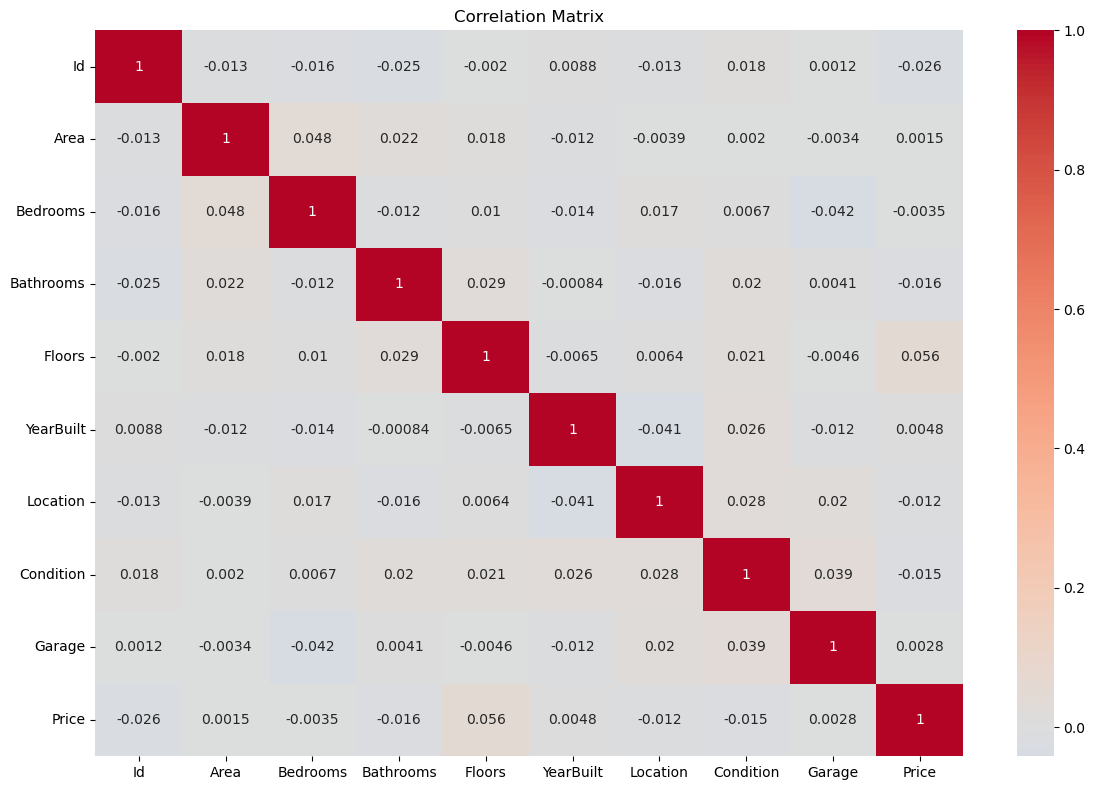

In [11]:
#checking the corelation matrix
plt.figure(figsize=(12,8))
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

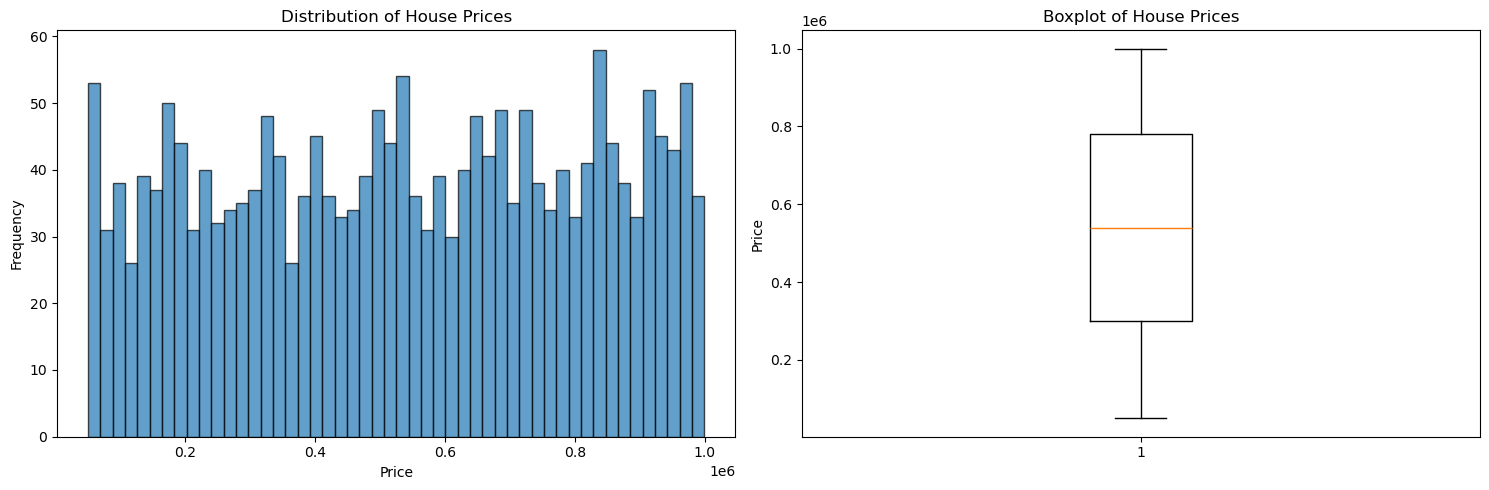

Price statistics:
count      2000.000000
mean     537676.855000
std      276428.845719
min       50005.000000
25%      300098.000000
50%      539254.000000
75%      780086.000000
max      999656.000000
Name: Price, dtype: float64


In [12]:
#distribution of target variable
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(df_clean['Price'], bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of House Prices")
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.boxplot(df_clean['Price'])
plt.title("Boxplot of House Prices")
plt.ylabel('Price')

plt.tight_layout()
plt.show()

print(f"Price statistics:\n{df_clean['Price'].describe()}")

In [13]:
#Outlier detection  for numerical columns using IQR method
numerical_columns = ['Area','Bedrooms','Bathrooms','Floors','YearBuilt']

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

print("Outlier detected using IQR method:")
for col in numerical_columns:
    outliers = detect_outliers_iqr(df_clean[col])
    print(f"{col}: {outliers} outliers")

Outlier detected using IQR method:
Area: 0 outliers
Bedrooms: 0 outliers
Bathrooms: 0 outliers
Floors: 0 outliers
YearBuilt: 0 outliers


In [26]:
#feature engineering
df_clean['Age']=2025 - df_clean['YearBuilt']
df_clean['RoomDensity']=df_clean['Bedrooms']+df_clean['Bathrooms']
df_clean['AreaPerRoom']=df_clean['Area'] / df_clean['RoomDensity'].replace(0,1)
df_clean['TotalRooms'] = df_clean['Bedrooms']+df_clean['Bathrooms']

#Check the new features correlation with price
new_features = ['Age','RoomDensity','AreaPerRoom','TotalRooms']
print("Correlation of new features with Price:")
for feature in new_features:
    corr = df_clean['Price'].corr(df_clean[feature])
    print(f"{feature}: {corr:.3f}")

Correlation of new features with Price:
Age: -0.005
RoomDensity: -0.012
AreaPerRoom: -0.011
TotalRooms: -0.012


### Exploratory Data Analaysis

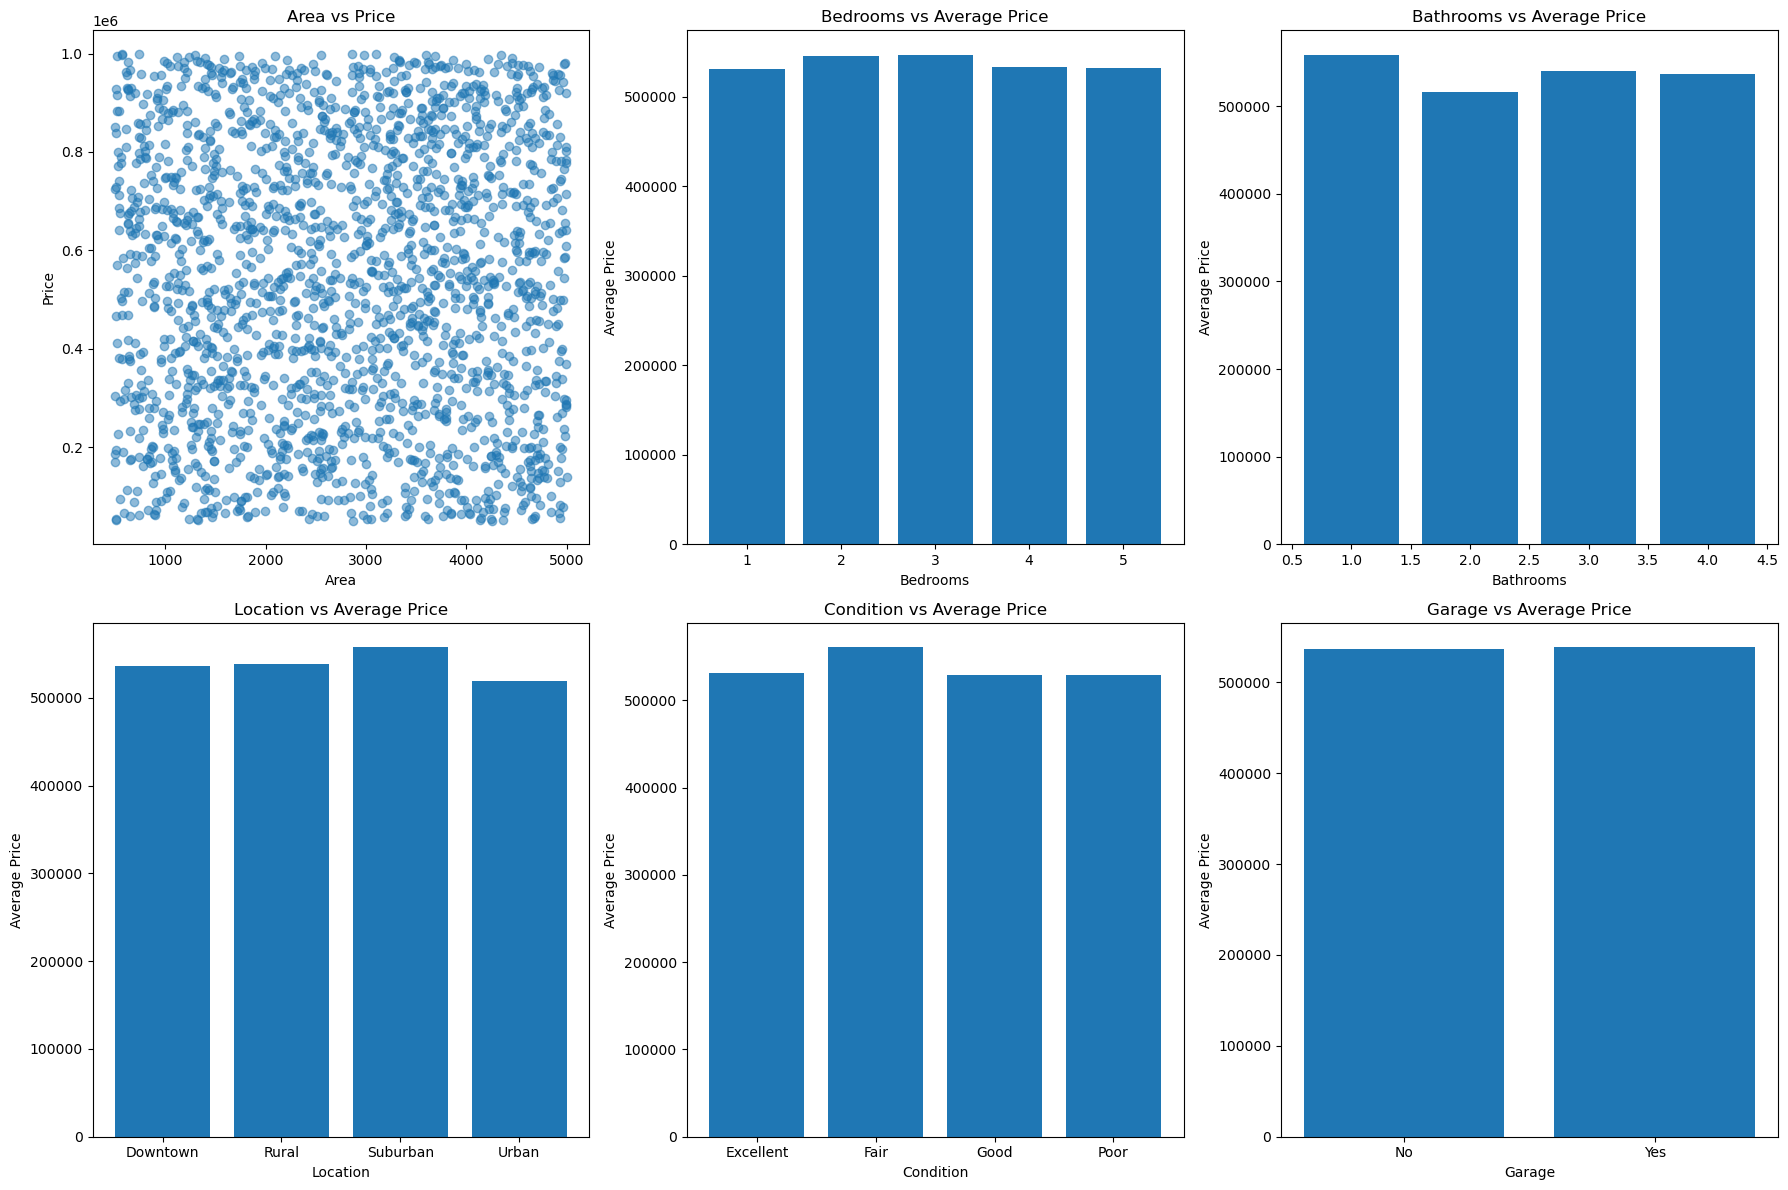

In [28]:
#Relationship between features and price
fig, axes = plt.subplots(2,3, figsize=(18,12))

#Area vs Price
axes[0,0].scatter(df_clean['Area'],df_clean['Price'],alpha=0.5)
axes[0,0].set_xlabel('Area')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Area vs Price')

#Bedrooms vs Price
bedroom_price = df_clean.groupby('Bedrooms')['Price'].mean()
axes[0,1].bar(bedroom_price.index, bedroom_price.values)
axes[0,1].set_xlabel('Bedrooms')
axes[0,1].set_ylabel('Average Price')
axes[0,1].set_title('Bedrooms vs Average Price')

#Bathrooms vs Price
bathroom_price = df_clean.groupby('Bathrooms')['Price'].mean()
axes[0,2].bar(bathroom_price.index, bathroom_price.values)
axes[0,2].set_xlabel('Bathrooms')
axes[0,2].set_ylabel('Average Price')
axes[0,2].set_title('Bathrooms vs Average Price')

#Location vs Price
location_price = df_clean.groupby('Location')['Price'].mean()
axes[1,0].bar(range(len(location_price)), location_price.values)
axes[1,0].set_xlabel('Location')
axes[1,0].set_ylabel('Average Price')
axes[1,0].set_title('Location vs Average Price')
axes[1,0].set_xticks(range(len(location_price)))
axes[1,0].set_xticklabels(['Downtown','Rural','Suburban','Urban'])

#Condition vs Price
condition_price = df_clean.groupby('Condition')['Price'].mean()
axes[1,1].bar(range(len(condition_price)), condition_price.values)
axes[1,1].set_xlabel('Condition')
axes[1,1].set_ylabel('Average Price')
axes[1,1].set_title('Condition vs Average Price')
axes[1,1].set_xticks(range(len(condition_price)))
axes[1,1].set_xticklabels(['Excellent','Fair','Good','Poor'])

#Garage vs Price
garage_price = df_clean.groupby('Garage')['Price'].mean()
axes[1,2].bar(range(len(garage_price)), garage_price.values)
axes[1,2].set_xlabel('Garage')
axes[1,2].set_ylabel('Average Price')
axes[1,2].set_title('Garage vs Average Price')
axes[1,2].set_xticks(garage_price.index)
axes[1,2].set_xticklabels(['No','Yes'])

plt.tight_layout()
plt.show()


### Preparing Data for Modelling

In [30]:
#preparing features and target
features = ['Area','Bedrooms','Bathrooms','Floors','YearBuilt','Location','Condition','Garage','Age','RoomDensity','AreaPerRoom','TotalRooms']

X = df_clean[features]
y = df_clean['Price']

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (1600, 12)
Test set size: (400, 12)


In [31]:
#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


### Model Training and Comparison

In [32]:
#Initializing the models.
models = {
    'Linear Regression' : LinearRegression(),
    'Ridge Regression' : Ridge(),
    'Lasso Regression' : Lasso(),
    'Random Forest' : RandomForestRegressor(random_state=42),
    'Gradient Boosting' : GradientBoostingRegressor(random_state=42),
    'Support Vector Regression' : SVR()
}

#Training and evaluating the model
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name == 'Support Vector Regression':
        #use scaled features for SVR
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    #Calculate the metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[name] = {
        'MSE' : mse,
        'MAE' : mae,
        'R2' : r2,
        'RMSE' : rmse
    }

    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Training Linear Regression...
Linear Regression - R2: -0.0152, RMSE: 281039.56, MAE: 244874.65
Training Ridge Regression...
Ridge Regression - R2: -0.0152, RMSE: 281037.64, MAE: 244873.14
Training Lasso Regression...
Lasso Regression - R2: -0.0152, RMSE: 281039.38, MAE: 244874.54
Training Random Forest...
Random Forest - R2: -0.1348, RMSE: 297128.16, MAE: 255287.60
Training Gradient Boosting...
Gradient Boosting - R2: -0.0516, RMSE: 286030.85, MAE: 246225.57
Training Support Vector Regression...
Support Vector Regression - R2: -0.0013, RMSE: 279110.44, MAE: 242647.76


In [33]:
#Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                                    MSE            MAE        R2  \
Support Vector Regression  7.790264e+10  242647.759454 -0.001334   
Ridge Regression           7.898215e+10  244873.139583 -0.015210   
Lasso Regression           7.898313e+10  244874.541431 -0.015223   
Linear Regression          7.898323e+10  244874.650723 -0.015224   
Gradient Boosting          8.181365e+10  246225.571214 -0.051605   
Random Forest              8.828514e+10  255287.597700 -0.134788   

                                    RMSE  
Support Vector Regression  279110.439850  
Ridge Regression           281037.636744  
Lasso Regression           281039.377169  
Linear Regression          281039.561036  
Gradient Boosting          286030.854849  
Random Forest              297128.158182  


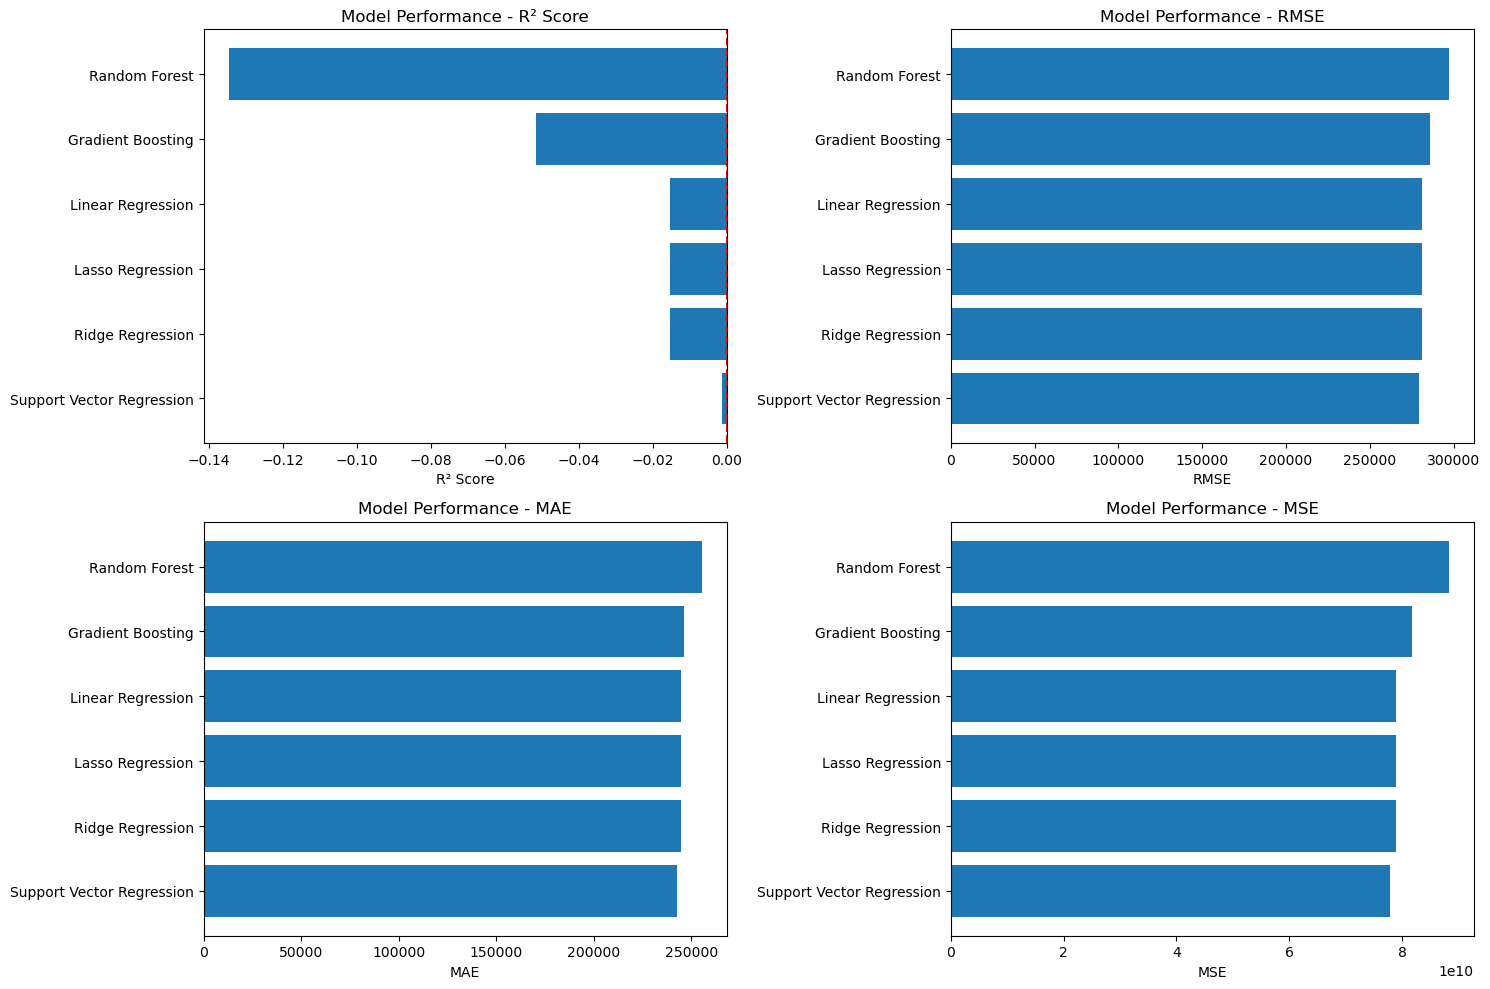

In [34]:
#Visualize model performance
fig, axes = plt.subplots(2,2,figsize=(15,10))

# R² Score
axes[0,0].barh(results_df.index, results_df['R2'])
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('Model Performance - R² Score')
axes[0,0].axvline(x=0, color='red', linestyle='--')

# RMSE
axes[0,1].barh(results_df.index, results_df['RMSE'])
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('Model Performance - RMSE')

# MAE
axes[1,0].barh(results_df.index, results_df['MAE'])
axes[1,0].set_xlabel('MAE')
axes[1,0].set_title('Model Performance - MAE')

# MSE
axes[1,1].barh(results_df.index, results_df['MSE'])
axes[1,1].set_xlabel('MSE')
axes[1,1].set_title('Model Performance - MSE')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning for Best Model

In [35]:
# Let's tune the best performing model (Random Forest)
print("Performing hyperparameter tuning for Random Forest...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: -0.0339


In [36]:
# Train best model with optimized parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Calculate metrics for tuned model
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)

print("Tuned Random Forest Performance:")
print(f"R² Score: {r2_best:.4f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"MSE: {mse_best:.2f}")

Tuned Random Forest Performance:
R² Score: -0.0652
RMSE: 287874.11
MAE: 249587.82
MSE: 82871503810.18


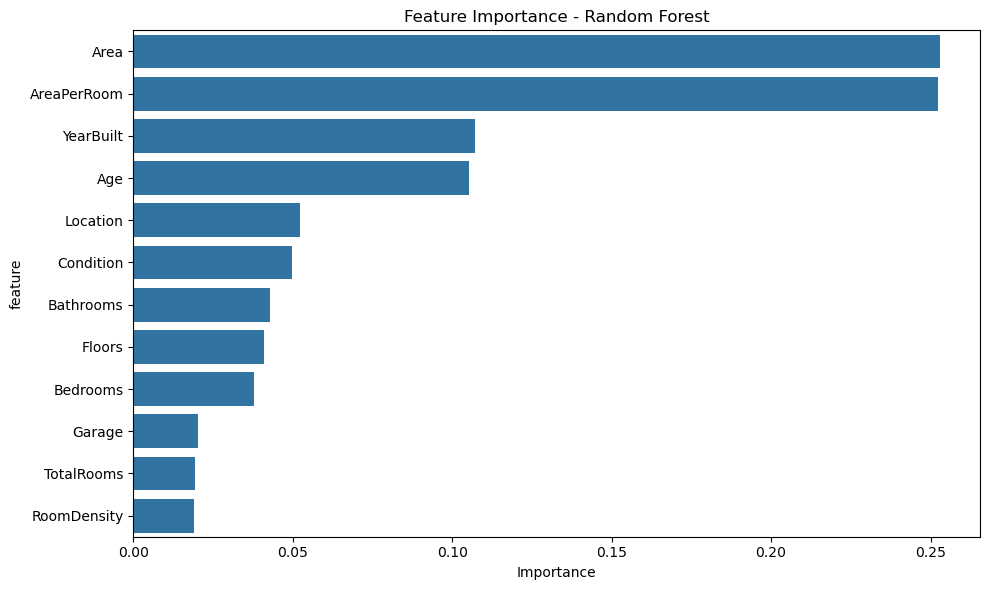

Feature Importance:
        feature  importance
0          Area    0.252858
10  AreaPerRoom    0.252333
4     YearBuilt    0.107105
8           Age    0.105408
5      Location    0.052296
6     Condition    0.049788
2     Bathrooms    0.042790
3        Floors    0.040907
1      Bedrooms    0.037831
7        Garage    0.020287
11   TotalRooms    0.019270
9   RoomDensity    0.019128


In [37]:
# Feature importance from best model
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Feature Importance:")
print(feature_importance)

### Model Diagnostics

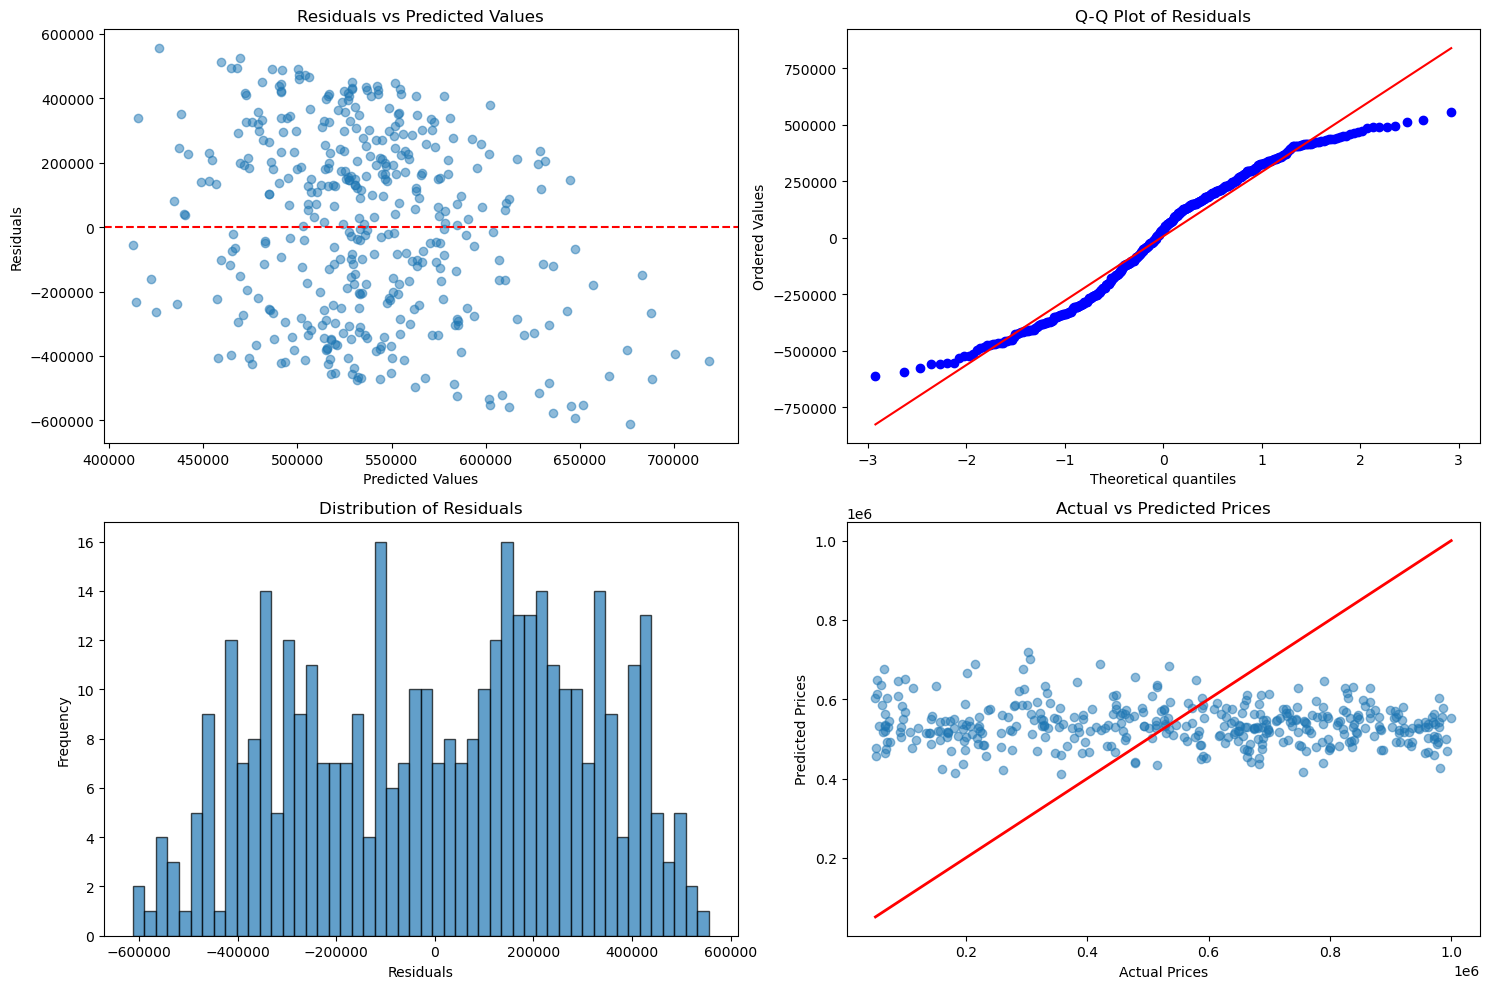

In [38]:
# Residual analysis for best model
residuals = y_test - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Predicted
axes[0,0].scatter(y_pred_best, residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Predicted Values')

# Q-Q plot of residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot of Residuals')

# Distribution of residuals
axes[1,0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')

# Actual vs Predicted
axes[1,1].scatter(y_test, y_pred_best, alpha=0.5)
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', lw=2)
axes[1,1].set_xlabel('Actual Prices')
axes[1,1].set_ylabel('Predicted Prices')
axes[1,1].set_title('Actual vs Predicted Prices')

plt.tight_layout()
plt.show()

In [39]:
# Calculate additional metrics for the best model
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred_best) * 100

print("Best Model Detailed Performance:")
print(f"R² Score: {r2_best:.4f}")
print(f"Adjusted R²: {1 - (1 - r2_best) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1):.4f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"MAPE: {mape:.2f}%")

Best Model Detailed Performance:
R² Score: -0.0652
Adjusted R²: -0.0982
RMSE: 287874.11
MAE: 249587.82
MAPE: 106.33%


### Saving the Best Model

In [40]:
# Save the best model and preprocessing objects
model_artifacts = {
    'model': best_rf,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'features': features
}

joblib.dump(model_artifacts, 'house_price_model.pkl')
print("Model and preprocessing artifacts saved successfully!")

# Also save individual components
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("All model components saved individually!")

Model and preprocessing artifacts saved successfully!
All model components saved individually!


### Creating Prediction Function

In [41]:
def predict_house_price(area, bedrooms, bathrooms, floors, year_built, location, condition, garage):
    """
    Predict house price using the trained model
    """
    # Load model artifacts
    artifacts = joblib.load('house_price_model.pkl')
    model = artifacts['model']
    scaler = artifacts['scaler']
    label_encoders = artifacts['label_encoders']
    features = artifacts['features']
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Area': [area],
        'Bedrooms': [bedrooms],
        'Bathrooms': [bathrooms],
        'Floors': [floors],
        'YearBuilt': [year_built],
        'Location': [location],
        'Condition': [condition],
        'Garage': [garage]
    })
    
    # Feature engineering
    input_data['Age'] = 2024 - input_data['YearBuilt']
    input_data['RoomDensity'] = input_data['Bedrooms'] + input_data['Bathrooms']
    input_data['AreaPerRoom'] = input_data['Area'] / input_data['RoomDensity'].replace(0, 1)
    input_data['TotalRooms'] = input_data['Bedrooms'] + input_data['Bathrooms']
    
    # Encode categorical variables
    for col in ['Location', 'Condition', 'Garage']:
        if col in label_encoders:
            input_data[col] = label_encoders[col].transform(input_data[col])
    
    # Ensure all features are present and in correct order
    input_data = input_data[features]
    
    # Scale features
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    return prediction

# Test the prediction function
sample_prediction = predict_house_price(
    area=2000, 
    bedrooms=3, 
    bathrooms=2, 
    floors=2, 
    year_built=2010, 
    location='Urban', 
    condition='Good', 
    garage='Yes'
)

print(f"Sample Prediction: ${sample_prediction:,.2f}")

Sample Prediction: $557,861.71


### Conclusion

In [42]:
print("="*50)
print("HOUSE PRICE PREDICTION MODEL - SUMMARY")
print("="*50)
print(f"Best Model: Random Forest Regressor")
print(f"Final R² Score: {r2_best:.4f}")
print(f"Final RMSE: {rmse_best:.2f}")
print(f"Final MAE: {mae_best:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Number of Features: {len(features)}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print("\nTop 5 Most Important Features:")
for i, row in feature_importance.head().iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")
print("="*50)

HOUSE PRICE PREDICTION MODEL - SUMMARY
Best Model: Random Forest Regressor
Final R² Score: -0.0652
Final RMSE: 287874.11
Final MAE: 249587.82
MAPE: 106.33%
Number of Features: 12
Training Samples: 1600
Test Samples: 400

Top 5 Most Important Features:
  Area: 0.2529
  AreaPerRoom: 0.2523
  YearBuilt: 0.1071
  Age: 0.1054
  Location: 0.0523
